#### bioReactor
---

In [1]:
#### INPUT DATA ####

# Gas properties
pressure_in = 1030 #mBar(a)
temperature_in = 12 #degC
density_in = 1.30 #kg/m3

# Reactor properties
reactor_biomass = 2500 #mg/l
reactor_length = 55.0 #m
reactor_width = 30.0 #m
reactor_depth = 5.5 #m

reactor_volume = reactor_length * reactor_depth * reactor_width

# Fluid properties
fluid_flow = 250 #ltr/s
fluid_alkalinity_in = 200 #mg/l

fluid_bod_in = 100 #mg/l
fluid_bod_out = 10 #mg/l

fluid_nh4_in = 30 #mg/l
fluid_nh4_out = 1.0 #mg/l

fluid_no3_in = 5.0 #mg/l
fluid_no3_out = 0.0 #mg/l

fluid_solids_in = 200 #mg/l
fluid_solids_out = 75 #mg/l

fluid_phosphate_in = 20 #mg/l
fluid_phosphate_out = 1.5 #mg/l

# Conversion factors
factor_bod = 1.00 #kgO2/h
factor_nh4 = 4.60 #kgO2/h
factor_no3 = -2.83 #kgO2/h
factor_biomass = 0.05 #kgO2/h

In [2]:
# Oxygen demand 
def oxygen_demand(factor, concentration_in, concentration_out, flowrate):
    return factor * flowrate * (concentration_in - concentration_out) * (3600 / 1e6)
    
demand_bod = oxygen_demand(factor_bod, fluid_bod_in, fluid_bod_out, fluid_flow)
demand_nh4 = oxygen_demand(factor_nh4, fluid_nh4_in, fluid_nh4_out, fluid_flow)
demand_no3 = oxygen_demand(factor_no3, fluid_no3_in, fluid_no3_out, fluid_flow)
demand_biomass = factor_biomass * reactor_biomass * reactor_volume * 0.001

demand_total = demand_bod + demand_nh4 + demand_no3 + demand_biomass

reactor_pop = (1000 * 24 / 8) * (demand_nh4 / factor_nh4)
print(f'Pop. of {round(reactor_pop)} based on 8g of ammonia per person per day (SEPA)')

Pop. of 78300 based on 8g of ammonia per person per day (SEPA)


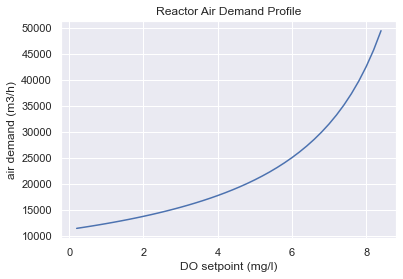

In [22]:
# Air demand
SOTE = 0.065 * (4 / reactor_depth)**0.25 # 6.5% @ 4m depth corrected
reactor_temperature = temperature_in #degC

DO_saturation = 0.0035 * reactor_temperature**2 - 0.3365 * reactor_temperature + 14.391 # mg/l
DO_setpoint = [0.1 * i for i in range(2, int(8 * DO_saturation),2)]

air_demand = {}
for i in DO_setpoint:
    kla = demand_total / ((DO_saturation - i) * reactor_volume) # per hr (mass_transfer_coefficient)
    SOTR = kla * DO_saturation * reactor_volume * 1.024**(reactor_temperature - 20) # kgO2/h
    flow_air_mass = SOTR / (SOTE * reactor_depth * 0.228) # kg/h
    flow_air_vol = flow_air_mass / density_in

    air_demand.update({round(i, 1):flow_air_vol})

import matplotlib.pyplot as plt, seaborn as sns
sns.set() 
plt.plot(air_demand.keys(), air_demand.values())
plt.ylabel('air demand (m3/h)')
plt.xlabel('DO setpoint (mg/l)')
plt.title('Reactor Air Demand Profile')
plt.show()

In [ ]:
# Solids & Hydraulic Retention Times
removed_solids_conc = 4000 #mg/l
removed_solids_rate = 600 #m3/d

reactor_srt = (reactor_volume * reactor_biomass) / (removed_solids_conc * removed_solids_rate) #days
reactor_hrt = reactor_volume / (fluid_flow * 3.6) #hr

# biomass
biomass_active = (0.99 * 24 * (demand_bod / factor_bod)) * reactor_srt / (1 + 0.24 * reactor_srt * 1.029**(reactor_temperature - 20)) # kg VSS
biomass_endogenous = 0.2 * biomass_active * 0.24 * reactor_srt * 1.029**(reactor_temperature - 20)# kg VSS
biomass_inert = 2.5 * reactor_srt * 24 * (demand_bod / factor_bod) * 0.13 / 1.48 # kg VSS
biomass_dosing = 6000 # kg SS to be added with calcs

biomass_total = biomass_active + biomass_endogenous + biomass_inert + biomass_dosing
reactor_fm_ratio = 24 * demand_bod / (factor_bod * biomass_total) #kg BOD / kg MLSS

biomass_surplus = 1000 * biomass_total / (reactor_srt * removed_solids_conc) # m3/d

biomass_surplus_var = removed_solids_rate - biomass_surplus

# Goal-seek waste rate...

        



print(f'Current reactor SRT: {round(reactor_srt, 1)} days')

Current reactor SRT: 9.5 days
